In [1]:
import scipy as sp
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
sp.__version__

'1.11.1'

In [3]:
def map_angles_to_n_sphere(angles, radius=1.0):
    # Convert angles to Cartesian coordinates on an n-sphere
    n = len(angles) +1  # Dimension of the n-sphere
    cartesian_coords = np.zeros(n) + radius
    cartesian_coords[0] = cartesian_coords[0]*np.cos(angles[0])
    for i in range(1,n-1):
        cartesian_coords[i] = cartesian_coords[i]*np.cos(angles[i])
        for j in range(i):
            cartesian_coords[i] = cartesian_coords[i]*np.sin(angles[j])
    for j in range(n-1):
        cartesian_coords[n-1] = cartesian_coords[n-1]*np.sin(angles[j])

    return cartesian_coords

In [4]:
g = [1,0,0,0]
s = [-1,0,0,0]

np.matmul(g,np.matmul(np.linalg.inv(Jx),s))
np.linalg.inv(Jx - np.outer(g, s))

NameError: name 'Jx' is not defined

In [5]:
def dx_norm(df,g,s, Jx):
    if np.matmul(g,np.matmul(np.linalg.inv(Jx),s)) == 1:
        return 100000
    else:
        return np.linalg.norm(np.matmul(np.linalg.inv(Jx - np.outer(g, s)), df))

In [44]:
def generate_evenly_distributed_vectors(n,k):
    vectors = []
    for i in range(k):
        angles = [np.random.rand()*2*np.pi for j in range(n-1)]
        vector = map_angles_to_n_sphere(angles)
        vectors.append(vector)
    return vectors

In [35]:
def generate_distributed_vectors(n,k,sigma):
    vectors = []
    mu = np.zeros(n) + 1
    mu = mu/np.linalg.norm(mu)
    vectors = sp.stats.vonmises_fisher.rvs(mu=mu, kappa = sigma,size = k)
    return vectors

In [21]:
help(sp.stats.vonmises_fisher)

Help on vonmises_fisher_gen in module scipy.stats._multivariate object:

class vonmises_fisher_gen(multi_rv_generic)
 |  vonmises_fisher_gen(seed=None)
 |  
 |  A von Mises-Fisher variable.
 |  
 |  The `mu` keyword specifies the mean direction vector. The `kappa` keyword
 |  specifies the concentration parameter.
 |  
 |  Methods
 |  -------
 |  pdf(x, mu=None, kappa=1)
 |      Probability density function.
 |  logpdf(x, mu=None, kappa=1)
 |      Log of the probability density function.
 |  rvs(mu=None, kappa=1, size=1, random_state=None)
 |      Draw random samples from a von Mises-Fisher distribution.
 |  entropy(mu=None, kappa=1)
 |      Compute the differential entropy of the von Mises-Fisher distribution.
 |  fit(data)
 |      Fit a von Mises-Fisher distribution to data.
 |  
 |  Parameters
 |  ----------
 |  mu : array_like
 |      Mean direction of the distribution. Must be a one-dimensional unit
 |      vector of norm 1.
 |  kappa : float
 |      Concentration parameter. Must 

In [9]:
generate_distributed_vectors(4,1000,0.01)

array([[-0.33003317,  0.31585004,  0.88949169, -0.01101814],
       [ 0.23738135, -0.5153658 , -0.04308876,  0.82230867],
       [-0.32874243, -0.09049278,  0.62943101, -0.69825216],
       ...,
       [ 0.14968301,  0.25134072, -0.17828947, -0.93948694],
       [-0.28953982, -0.18273834,  0.50647385, -0.79136441],
       [-0.28326851, -0.55573066, -0.67212686, -0.39895848]])

In [11]:
def avg_dx_norm_old(s,g, Jx):
    n = len(s)
    return np.mean([dx_norm(df,g,s, Jx) for df in generate_evenly_distributed_vectors(n,100)])

In [37]:
def avg_dx_norm(s,g, Jx,sigma):
    n = len(s)
    return np.mean([dx_norm(df,g,s, Jx) for df in generate_distributed_vectors(n,100,sigma)])

In [55]:
def avg_dx_norm_single(s,g, Jx):
    n = len(s)
    df = np.zeros(n) + 1
    df = df/np.linalg.norm(df)
    return dx_norm(df,g,s, Jx)

In [36]:
def optimize_sg(Jx,sigma):
    n = Jx.shape[0]
    bounds = [[0,np.pi] for i in range(n-2)]
    bounds.append([0,2*np.pi])
    for i in range(n-2):
        bounds.append([0,np.pi])
    bounds.append([0,2*np.pi])
    print(n)
    initial_guess = np.zeros(2*(n-1))+np.pi/8
    # Minimize the negative dot product to maximize the dot product
    result = sp.optimize.basinhopping(
        lambda x: avg_dx_norm(map_angles_to_n_sphere(x[:(n-1)]), map_angles_to_n_sphere(x[(n-1):]),Jx,sigma),
        initial_guess,
        minimizer_kwargs={"bounds": bounds})

    optimized_s = map_angles_to_n_sphere(result.x[:(n-1)])
    optimized_g = map_angles_to_n_sphere(result.x[(n-1):])
    return optimized_s, optimized_g

In [56]:
def optimize_sg_old(Jx):
    n = Jx.shape[0]
    bounds = [[0,np.pi] for i in range(n-2)]
    bounds.append([0,2*np.pi])
    for i in range(n-2):
        bounds.append([0,np.pi])
    bounds.append([0,2*np.pi])
    print(n)
    initial_guess = np.zeros(2*(n-1))+np.pi/8
    # Minimize the negative dot product to maximize the dot product
    result = sp.optimize.basinhopping(
        lambda x: avg_dx_norm_single(map_angles_to_n_sphere(x[:(n-1)]), map_angles_to_n_sphere(x[(n-1):]),Jx),
        initial_guess,
        minimizer_kwargs={"bounds": bounds})

    optimized_s = map_angles_to_n_sphere(result.x[:(n-1)])
    optimized_g = map_angles_to_n_sphere(result.x[(n-1):])
    return optimized_s, optimized_g

In [100]:
def optimize_sg_constrained_4(Jx):
    n = 4
    bounds = [[0,2*np.pi] for i in range(2)]

    print(n)
    initial_guess = np.zeros(2)+np.pi/8
    # Minimize the negative dot product to maximize the dot product
    result = sp.optimize.basinhopping(
        lambda x: avg_dx_norm(map_angles_to_n_sphere([x[0],0,0]), map_angles_to_n_sphere([x[1],0,0]),Jx),
        initial_guess,
        minimizer_kwargs={"bounds": bounds})

    optimized_s = map_angles_to_n_sphere([result.x[0],0,0])
    optimized_g = map_angles_to_n_sphere([result.x[1],0,0])
    return avg_dx_norm(optimized_s, optimized_g,Jx)

In [86]:

n = 2
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -2
mode_gaps = -np.logspace(0, -8, num=50,  base=2)
gs = []
ss = []
for i in tqdm(range(len(mode_gaps))):
    Jx[1,1] = mode_gaps[i]
    s,g = optimize_sg_old(Jx)
    gs.append(g)
    ss.append(s)

  0%|                                                 | 0/50 [00:00<?, ?it/s]

2


  2%|▊                                        | 1/50 [00:00<00:41,  1.17it/s]

2


  4%|█▋                                       | 2/50 [00:01<00:34,  1.41it/s]

2


  6%|██▍                                      | 3/50 [00:01<00:28,  1.67it/s]

2


  8%|███▎                                     | 4/50 [00:02<00:24,  1.87it/s]

2


 10%|████                                     | 5/50 [00:02<00:22,  2.00it/s]

2


 12%|████▉                                    | 6/50 [00:03<00:21,  2.06it/s]

2


 14%|█████▋                                   | 7/50 [00:03<00:20,  2.11it/s]

2


 16%|██████▌                                  | 8/50 [00:04<00:18,  2.23it/s]

2


 18%|███████▍                                 | 9/50 [00:04<00:17,  2.28it/s]

2


 20%|████████                                | 10/50 [00:04<00:17,  2.29it/s]

2


 22%|████████▊                               | 11/50 [00:05<00:16,  2.36it/s]

2


 24%|█████████▌                              | 12/50 [00:05<00:16,  2.37it/s]

2


 26%|██████████▍                             | 13/50 [00:06<00:15,  2.42it/s]

2


 28%|███████████▏                            | 14/50 [00:06<00:14,  2.40it/s]

2


 30%|████████████                            | 15/50 [00:07<00:15,  2.33it/s]

2


 32%|████████████▊                           | 16/50 [00:07<00:14,  2.35it/s]

2


 34%|█████████████▌                          | 17/50 [00:07<00:14,  2.30it/s]

2


 36%|██████████████▍                         | 18/50 [00:08<00:13,  2.32it/s]

2


 38%|███████████████▏                        | 19/50 [00:08<00:13,  2.32it/s]

2


 40%|████████████████                        | 20/50 [00:09<00:12,  2.37it/s]

2


 42%|████████████████▊                       | 21/50 [00:09<00:12,  2.38it/s]

2


 44%|█████████████████▌                      | 22/50 [00:09<00:11,  2.41it/s]

2


 46%|██████████████████▍                     | 23/50 [00:10<00:11,  2.37it/s]

2


 48%|███████████████████▏                    | 24/50 [00:10<00:11,  2.34it/s]

2


 50%|████████████████████                    | 25/50 [00:11<00:10,  2.32it/s]

2


 52%|████████████████████▊                   | 26/50 [00:11<00:10,  2.33it/s]

2


 54%|█████████████████████▌                  | 27/50 [00:12<00:09,  2.38it/s]

2


 56%|██████████████████████▍                 | 28/50 [00:12<00:09,  2.34it/s]

2


 58%|███████████████████████▏                | 29/50 [00:12<00:08,  2.37it/s]

2


 60%|████████████████████████                | 30/50 [00:13<00:08,  2.35it/s]

2


 62%|████████████████████████▊               | 31/50 [00:13<00:08,  2.30it/s]

2


 64%|█████████████████████████▌              | 32/50 [00:14<00:07,  2.27it/s]

2


 66%|██████████████████████████▍             | 33/50 [00:14<00:07,  2.22it/s]

2


 68%|███████████████████████████▏            | 34/50 [00:15<00:07,  2.21it/s]

2


 70%|████████████████████████████            | 35/50 [00:15<00:06,  2.24it/s]

2


 72%|████████████████████████████▊           | 36/50 [00:16<00:06,  2.29it/s]

2


 74%|█████████████████████████████▌          | 37/50 [00:16<00:05,  2.29it/s]

2


 76%|██████████████████████████████▍         | 38/50 [00:17<00:05,  2.23it/s]

2


 78%|███████████████████████████████▏        | 39/50 [00:17<00:04,  2.26it/s]

2


 80%|████████████████████████████████        | 40/50 [00:17<00:04,  2.26it/s]

2


 82%|████████████████████████████████▊       | 41/50 [00:18<00:04,  2.19it/s]

2


 84%|█████████████████████████████████▌      | 42/50 [00:18<00:03,  2.17it/s]

2


 86%|██████████████████████████████████▍     | 43/50 [00:19<00:03,  2.18it/s]

2


 88%|███████████████████████████████████▏    | 44/50 [00:19<00:02,  2.14it/s]

2


 90%|████████████████████████████████████    | 45/50 [00:20<00:02,  2.17it/s]

2


 92%|████████████████████████████████████▊   | 46/50 [00:20<00:01,  2.07it/s]

2


 94%|█████████████████████████████████████▌  | 47/50 [00:21<00:01,  2.11it/s]

2


 96%|██████████████████████████████████████▍ | 48/50 [00:21<00:00,  2.10it/s]

2


 98%|███████████████████████████████████████▏| 49/50 [00:22<00:00,  1.71it/s]

2


100%|████████████████████████████████████████| 50/50 [00:23<00:00,  2.17it/s]


In [53]:
g_von = np.array(gs)
s_von = np.array(ss)

In [49]:
mode_gaps = [-2,-1,-.5,-.25,-.125,-.0625,-.03125,-.03125/2]
Jx[2,2] = mode_gaps[-1]
s,g = optimize_sg(Jx,10000)
gs.append(g)
ss.append(s)

4


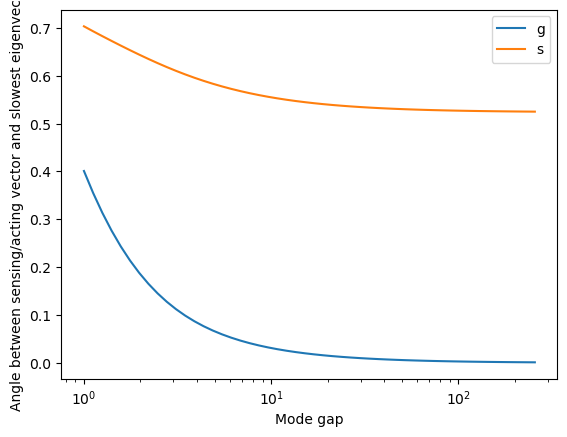

In [88]:
#mode_gaps = [-2,-1,-.5,-.25,-.125,-.0625,-.03125,-.03125/2]
mode_gaps = -np.logspace(0, -8, num=50,  base=2)
plt.plot(-1/(np.array(mode_gaps)), np.arccos(np.abs([np.dot(g,[0,1]) for g in gs])),label='g')
plt.plot(-1/(np.array(mode_gaps)), np.arccos(np.abs([np.dot(s,[0,1]) for s in ss])),label = 's')
plt.xscale('log')
plt.ylabel('Angle between sensing/acting vector and slowest eigenvector')
plt.xlabel('Mode gap')
plt.legend()

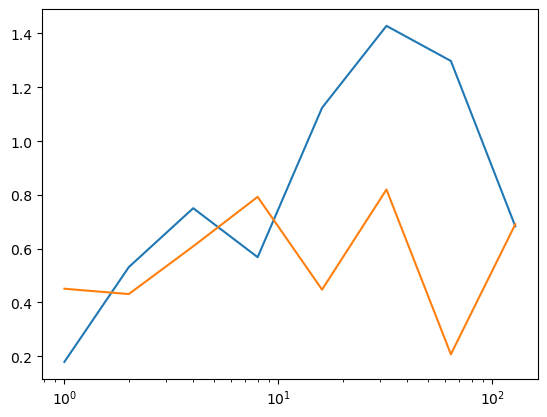

In [85]:
n = 4
mu = np.zeros(n) + 1
mu = mu/np.linalg.norm(mu)
plt.plot(1/(np.array(mode_gaps)/-2), np.arccos(np.abs([np.dot(g,mu) for g in g_von])))
plt.plot(1/(np.array(mode_gaps)/-2), np.arccos(np.abs([np.dot(s,mu) for s in s_von])))
plt.xscale('log')

In [67]:
gs[0]

array([0.35526836, 0.35526666, 0.78826085, 0.35526726])

In [40]:
n = 4
mu = np.zeros(n) + 1
mu = mu/np.linalg.norm(mu)
sigma = 100000
sp.stats.vonmises_fisher.rvs(mu=mu, kappa = sigma,size = 5)

array([[0.50027712, 0.50035241, 0.49790621, 0.50145755],
       [0.50197428, 0.50053101, 0.49938261, 0.49810394],
       [0.50203466, 0.49982103, 0.49865503, 0.49948303],
       [0.50037785, 0.49961032, 0.49634707, 0.50363788],
       [0.50079495, 0.49965677, 0.5016969 , 0.4978431 ]])

In [182]:
results = []
Jxs = []
for j in tqdm(range(30)):    
    n = 4
    D = np.zeros((n,n))
    for i in range(n):
        D[i,i] = -1

    D[1,1] = -0.001

    P = gram_schmidt(np.random.rand(4,4))
    Jx = np.matmul(np.matmul(P,D),np.linalg.inv(P))
    results.append(optimize_sg_constrained_4(Jx))
    Jxs.append(Jx)


  0%|                                                 | 0/30 [00:00<?, ?it/s]

4


  3%|█▎                                       | 1/30 [00:31<15:27, 32.00s/it]

4


  7%|██▋                                      | 2/30 [01:04<14:56, 32.02s/it]

4


 10%|████                                     | 3/30 [01:33<13:52, 30.84s/it]

4


 13%|█████▍                                   | 4/30 [02:06<13:46, 31.80s/it]

4


 17%|██████▊                                  | 5/30 [02:40<13:30, 32.42s/it]

4


 20%|████████▏                                | 6/30 [03:12<12:57, 32.40s/it]

4


 23%|█████████▌                               | 7/30 [03:44<12:18, 32.11s/it]

4


 27%|██████████▉                              | 8/30 [04:17<11:57, 32.62s/it]

4


 30%|████████████▎                            | 9/30 [04:53<11:44, 33.56s/it]

4


 33%|█████████████▎                          | 10/30 [05:25<10:59, 32.96s/it]

4


 37%|██████████████▋                         | 11/30 [05:59<10:37, 33.55s/it]

4


 40%|████████████████                        | 12/30 [06:33<10:01, 33.41s/it]

4


 43%|█████████████████▎                      | 13/30 [07:10<09:50, 34.74s/it]

4


 47%|██████████████████▋                     | 14/30 [07:43<09:03, 33.98s/it]

4


 50%|████████████████████                    | 15/30 [08:19<08:39, 34.63s/it]

4


 53%|█████████████████████▎                  | 16/30 [08:54<08:09, 34.96s/it]

4


 57%|██████████████████████▋                 | 17/30 [09:32<07:42, 35.59s/it]

4


 60%|████████████████████████                | 18/30 [10:01<06:46, 33.86s/it]

4


 63%|█████████████████████████▎              | 19/30 [10:37<06:17, 34.29s/it]

4


 67%|██████████████████████████▋             | 20/30 [11:11<05:42, 34.29s/it]

4


 70%|████████████████████████████            | 21/30 [11:46<05:09, 34.44s/it]

4


 73%|█████████████████████████████▎          | 22/30 [12:20<04:34, 34.27s/it]

4


 77%|██████████████████████████████▋         | 23/30 [12:58<04:07, 35.36s/it]

4


 80%|████████████████████████████████        | 24/30 [13:39<03:43, 37.27s/it]

4


 83%|█████████████████████████████████▎      | 25/30 [14:18<03:08, 37.66s/it]

4


 87%|██████████████████████████████████▋     | 26/30 [15:00<02:36, 39.10s/it]

4


 90%|████████████████████████████████████    | 27/30 [15:39<01:56, 38.96s/it]

4


 93%|█████████████████████████████████████▎  | 28/30 [16:16<01:16, 38.30s/it]

4


 97%|██████████████████████████████████████▋ | 29/30 [16:50<00:36, 36.97s/it]

4


100%|████████████████████████████████████████| 30/30 [17:29<00:00, 34.97s/it]


In [194]:
axis_frac = [np.sum([np.abs(Jxs[j][i,i]) for i in range(4)])/np.sum(np.abs(Jxs[j])) for j in range(len(Jxs))]

In [192]:
axis_frac = [np.abs(Jxs[j][1,1])/np.sum(np.abs(Jxs[j])) for j in range(len(Jxs))]

(0.0, 10.0)

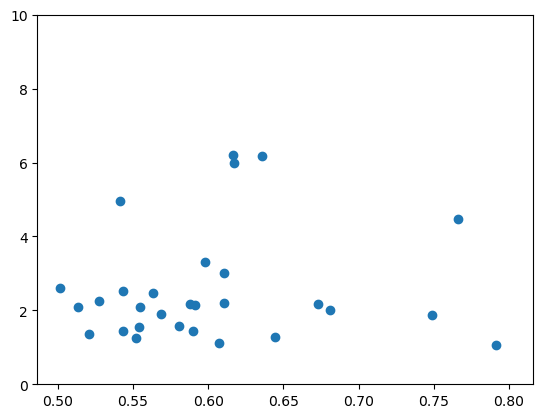

In [195]:
plt.scatter(axis_frac,results)
plt.ylim([0,10])

In [187]:
np.sum([np.abs(Jxs[j][i,i]) for i in range(4)])/np.sum(np.abs(Jxs[j]))

0.5434977395308782

In [176]:
np.round(P,2)

array([[ 0.38,  0.28,  0.76,  0.45],
       [ 0.9 , -0.32, -0.21, -0.21],
       [ 0.2 ,  0.91, -0.29, -0.24],
       [ 0.08,  0.03, -0.54,  0.84]])

In [76]:
def evs(a,b,c):
    return [map_angles_to_n_sphere([0+a,0+b,0+c]),
            map_angles_to_n_sphere([np.pi/2+a,np.pi/2+b,0+c]),
            map_angles_to_n_sphere([np.pi/2+a,0+b,0+c]),
            map_angles_to_n_sphere([np.pi/2+a,np.pi/2+b,np.pi/2+c])]

In [79]:
def hopf_coord(theta):
    return [np.cos(theta[0])*np.sin(theta[1]),
            np.sin(theta[0])*np.sin(theta[1]),
            np.cos(theta[2])*np.cos(theta[1]),
            np.sin(theta[2])*np.cos(theta[1])]


In [121]:
def evs(a,b,c):
    return [hopf_coord([0+a,np.pi/2,0+b]),
            hopf_coord([np.pi/2+a,np.pi/2,0+b]),
            hopf_coord([0+a,0,0+b]),
            hopf_coord([0+a,0,np.pi/2+b])]

In [132]:
a = .2
b = .2
c = .1
np.dot(evs(a,b,c)[0],evs(a,b,c)[1])


8.326672684688674e-17

In [98]:
P = np.stack(evs(.2,.4),axis = 1)
P[:,0]

array([9.80066578e-01, 1.98669331e-01, 5.63987199e-17, 2.38449963e-17])

In [99]:
evs(.2,.4)[0]

[0.9800665778412416,
 0.19866933079506122,
 5.639871990625564e-17,
 2.384499632187786e-17]

In [82]:
hopf_coord([0,np.pi/2,0])
hopf_coord([np.pi/2,np.pi/2,0])
hopf_coord([0,0,0])
hopf_coord([0,0,np.pi/2])

[1.0, 0.0, 6.123233995736766e-17, 0.0]
[6.123233995736766e-17, 1.0, 6.123233995736766e-17, 0.0]
[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 6.123233995736766e-17, 1.0]


In [77]:
ev = evs(1,0,0)

In [75]:
np.dot(ev[2],ev[1])

0.7080734182735712

(array([  0.,   7.,   0., 266.,   0.,   0., 726.,   0.,   0.,   1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 <BarContainer object of 10 artists>)

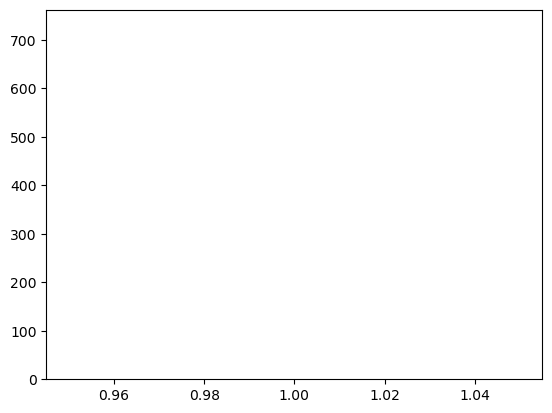

In [18]:
plt.hist([np.linalg.norm(map_angles_to_n_sphere(np.random.rand(4)*10)) for i in range(1000)])

In [40]:
avg_dx_norm(map_angles_to_n_sphere(np.random.rand(n-1)),map_angles_to_n_sphere(np.random.rand(n-1)),Jx)

5.6339043248944245

In [15]:
bounds = [[0,np.pi] for i in range(n-2)]
bounds.append([0,2*np.pi])
for i in range(n-2):
    bounds.append([0,np.pi])
bounds.append([0,2*np.pi])

bounds

[[0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 6.283185307179586],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 6.283185307179586]]

In [146]:
def gram_schmidt(vectors):
    num_vectors, vector_dim = vectors.shape
    orthogonalized_vectors = np.zeros((num_vectors, vector_dim))

    for i in range(num_vectors):
        v = vectors[i]
        for j in range(i):
            u = orthogonalized_vectors[j]
            v = v - np.dot(v, u) / np.dot(u, u) * u
        orthogonalized_vectors[i] = v / np.linalg.norm(v)

    return orthogonalized_vectors


In [156]:
P = gram_schmidt(np.random.rand(4,4))
np.dot(P[0,:],P[0,:])

1.0000000000000002

In [158]:
np.linalg.norm(P[0,:])

1.0